In [1]:
import pandas as pd

import glob

path='c:\\Users\dougw\Desktop\Analise-Polybench\Logs de Energia'

files = [f for f in glob.glob(path + "**/*.txt", recursive=True)]

for f in files:
    print(f)

c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_177000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_266000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_350000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_420000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_480000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_543000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2DCONV_GPU_600000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2MM_GPU_177000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\Analise-Polybench\Logs de Energia\2MM_GPU_266000000_IdlesFreq_1GHZ_log_energia.txt
c:\Users\dougw\Desktop\An

In [2]:
def group_results(file,name):
    df_temp = pd.DataFrame()
    dict_temp = {}    

    for line in file:
        if ":" in line:
            if line[0] == 'm':
                break
                
            key, value = line.split(':')[0], float(line.split(':')[1])
            dict_temp[key] =  float(value)
            #print(key,':',value)
        else: 
            if 'm' in line:
                key = line.split('\t')[0]
                mi = int(line.split('\t')[1].split('m')[0])
                se = float(line.split('\t')[1].split('m')[1].replace('s',''))
                value = mi*60 + se
                dict_temp[key] =  float(value)
                #print(key,':',value)
                if "sys" in line:
                    df_temp = df_temp.append(dict_temp, ignore_index=True)
                    dict_temp = dict.fromkeys(dict_temp, 0)
    
    df_temp = df_temp.mean().to_dict()
    
    app = name.split('\\')[-1].split('_')[0]
    dev = name.split('_')[1]
    dev_freq = int(name.split('_')[2])
    
    df_temp['App'] = app
    df_temp['Freq'] = dev_freq
    df_temp['Dev'] = str(dev)
    
    return df_temp

In [3]:
df = pd.DataFrame()

for path in files:
    log_data=open(path,'r')
    temp_dict = group_results(log_data, path)
    df = df.append(temp_dict, ignore_index=True)

to_remove = ['App','Dev','sys','user']
df.set_index(['Freq'], inplace=True)
df['Total_Acumulada'] = df.loc[:,~df.columns.isin(to_remove)].sum(axis=1)
df = df.reset_index()
df['EDP'] = df['Total_Acumulada']*df['real']
df['A15_Power'] = df['A15_Acumulada']/df['real']
df['A7_Power'] = df['A7_Acumulada']/df['real']
df['MEM_Power'] = df['MEM_Acumulada']/df['real']
df['GPU_Power'] = df['GPU_Acumulada']/df['real']


col = df['GPU_Acumulada']
df.drop(labels=['GPU_Acumulada'], axis=1,inplace = True)
df.insert(0, 'GPU_Acumulada', col)
col = df['Total_Acumulada']
df.drop(labels=['Total_Acumulada'], axis=1,inplace = True)
df.insert(0, 'Total_Acumulada', col)
col = df['Dev']
df.drop(labels=['Dev'], axis=1,inplace = True)
df.insert(0, 'Dev', col)
col = df['Freq']
df.drop(labels=['Freq'], axis=1,inplace = True)
df.insert(0, 'Freq', col)
col = df['App']
df.drop(labels=['App'], axis=1,inplace = True)
df.insert(0, 'App', col)


In [4]:
def Type(x):
    if '2DCONV' in x or '3DCONV' in x:
        return 'Convolution'  
    elif '2MM' in x or '3MM' in x or 'ATAX' in x or 'BICG' in x or 'GEMM' in x or 'GESUMMV' in x or 'GRAMSCHM' in x or 'MVT' in x or 'SYR2K' in x or 'SYRK' in x:
        return 'Linear_Algebra' 
    elif 'CORR' in x or 'COVAR' in x:
        return 'Datamining' 
    elif 'FDTD-2D' in x:
        return 'Stencils' 

df["Type"] = df["App"].apply(Type)    
df['Freq'] = pd.to_numeric(df['Freq'] / 1000000)
df['Freq'] = df['Freq'].map('{0:g}'.format).astype(str)
df

,App,Freq,Dev,Total_Acumulada,GPU_Acumulada,A15_Acumulada,A7_Acumulada,MEM_Acumulada,real,sys,user,EDP,A15_Power,A7_Power,MEM_Power,GPU_Power,Type
0,2DCONV,177,GPU,10.947489,0.337780,3.403971,0.413798,0.596306,6.195633,1.091633,4.707400,67.826627,0.549415,0.066789,0.096246,0.054519,Convolution
1,2DCONV,266,GPU,10.378181,0.292762,3.129412,0.378646,0.526093,6.051267,1.045933,4.704767,62.801139,0.517150,0.062573,0.086939,0.048380,Convolution
2,2DCONV,350,GPU,10.192914,0.250533,3.040314,0.370649,0.501118,6.030300,1.023567,4.712800,61.466331,0.504173,0.061464,0.083100,0.041546,Convolution
3,2DCONV,420,GPU,10.147384,0.352595,2.963701,0.361794,0.491793,5.977500,1.005133,4.722133,60.655986,0.495809,0.060526,0.082274,0.058987,Convolution
4,2DCONV,480,GPU,10.815156,0.466747,3.439572,0.368612,0.534291,6.005933,1.028167,4.731467,64.955107,0.572696,0.061375,0.088961,0.077714,Convolution
5,2DCONV,543,GPU,10.176625,0.387990,2.970968,0.360697,0.493903,5.963067,1.025233,4.708533,60.683894,0.498228,0.060489,0.082827,0.065066,Convolution
6,2DCONV,600,GPU,10.168003,0.390061,2.979464,0.360785,0.487193,5.950500,1.002533,4.722133,60.504699,0.500708,0.060631,0.081874,0.065551,Convolution
7,2MM,177,GPU,191.427443,52.325207,20.157730,6.243570,8.938003,103.762933,0.811267,0.307267,19863.072972,0.194267,0.060171,0.086139,0.504276,Linear_Algebra
8,2MM,266,GPU,146.306138,51.544303,13.909800,4.297825,6.377143,70.177067,0.811067,0.305933,10267.335600,0.198210,0.061243,0.090872,0.734489,Linear_Algebra
9,2MM,350,GPU,125.908290,51.947573,11.191210,3.383405,5.149301,54.236800,0.802900,0.315767,6828.862743,0.206340,0.062382,0.094941,0.957792,Linear_Algebra


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

apps = list(set(df['App']))
dict_plot = {}
to_mantain = ['EDP','Freq','App']

for app in apps:
    df_plot = df.loc[:,df.columns.isin(to_mantain)] 
    dict_plot[app] = ggplot(df_plot[df_plot['App'] == app], aes(x='Freq', y='EDP', group = 'App')) +\
         geom_bar(position="stack", stat="identity") +\
         labs(x = "Frequency x100MHz", title=app) +\
         theme_minimal() +\
         theme(axis_text_x = element_text(angle=0, hjust=1, size=10), axis_text_y = element_text(angle=0, hjust=1, size=10))

In [40]:
for app in apps:
    dict_plot[app].save(app + '_plot.pdf')

c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: FDTD-2D_plot.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: 2DCONV_plot.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
c:\users\dougw\appdata

c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 16 x 9 in image.
  from_inches(height, units), units), PlotnineWarning)
c:\users\dougw\appdata\local\programs\python\python37\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: conv_plot.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


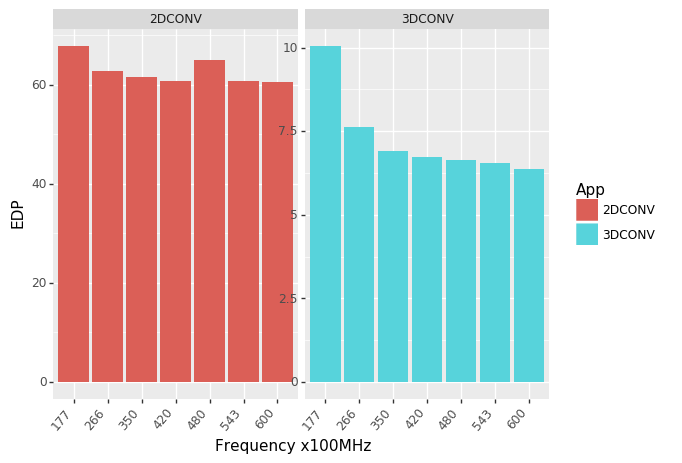

<ggplot: (-9223371903933552703)>


In [7]:

Convolution_plot = (ggplot(df[df['Type'] == 'Convolution'], aes(x='Freq', y='EDP', fill='App', group = 'App')) +\
 geom_bar(position="stack", stat="identity") +\
 facet_wrap(["App"], scales = "free",nrow=5,ncol=3) +\
 labs(x = "Frequency x100MHz") +\
 theme(axis_text_x = element_text(angle=50, hjust=1))
)

Convolution_plot.save('conv_plot.pdf', width = 16, height = 9)
print(Convolution_plot)

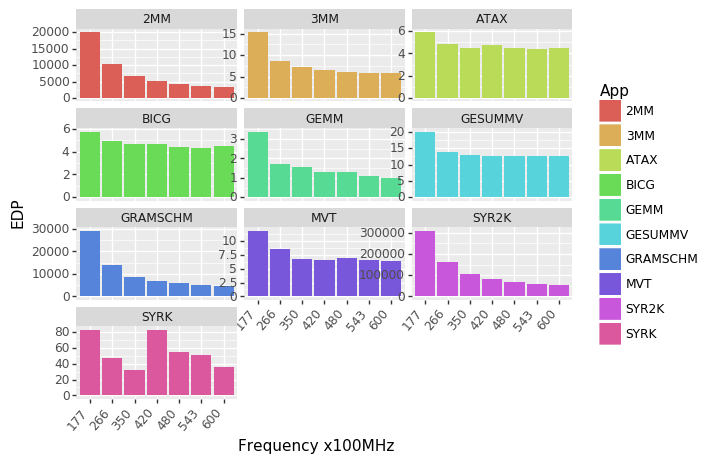

<ggplot: (-9223371903934881890)>

In [8]:

(ggplot(df[df['Type'] == 'Linear_Algebra'], aes(x='Freq', y='EDP', fill='App', group = 'App')) +\
 geom_bar(position="stack", stat="identity") +\
 facet_wrap(["App"], scales = "free_y",nrow=4,ncol=3) +\
 labs(x = "Frequency x100MHz") +\
 theme(axis_text_x = element_text(angle=50, hjust=1))
)


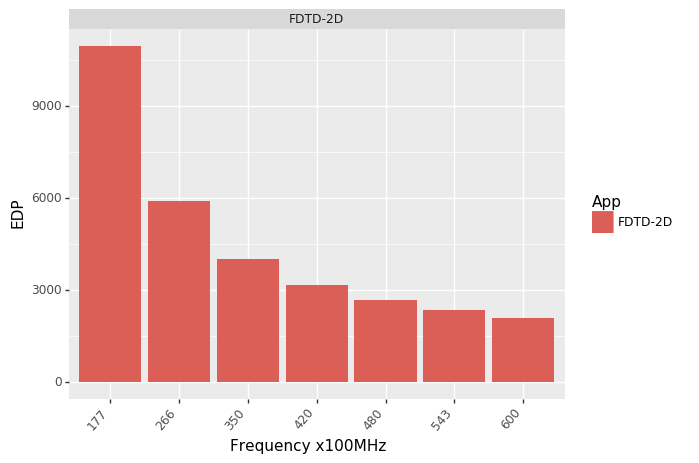

<ggplot: (132920051804)>

In [9]:

(ggplot(df[df['Type'] == 'Stencils'], aes(x='Freq', y='EDP', fill='App', group = 'App')) +\
 geom_bar(position="stack", stat="identity") +\
 facet_wrap(["App"], scales = "free_y",nrow=4,ncol=4) +\
 labs(x = "Frequency x100MHz") +\
 theme(axis_text_x = element_text(angle=50, hjust=1))
)
